In [7]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
from sklearn.neural_network import MLPRegressor

In [8]:
### 构建时间序列特征集
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# 加载数据集
dataset = pd.read_excel("Tibet.xlsx")
fratures_Corrected_irradiance = [
   '震级(M)', '纬度(°)', '经度(°)'
]
values= dataset[fratures_Corrected_irradiance].values

In [10]:
values.shape

(761, 3)

In [11]:
# 确保所有数据是浮动的
values = values.astype('float32')
n_in=3
n_out=1
n_vars=3

# 构建成监督学习问题
reframed = series_to_supervised(values, n_in, n_out)  # 预测时间步长为3 ，输出时间步1  ，即由t-3,t-2,....t-1预测t


In [12]:
#取出保留的变量
contain_vars = []
for i in range(1, n_in+1):
    contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]  
data = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]

In [13]:
# 把数据集分为训练集和测试集
values = data.values
n_train_hours = 609 # 80%数据训练
train = values[:n_train_hours, :]  # 前7000组数据训练 验证
test = values[n_train_hours:, :]   # 后1761组预测

In [14]:
# 标准化
scaler =  StandardScaler()
train = scaler.fit_transform(train)
test =  scaler.fit_transform(test)

In [15]:
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [16]:
print("train_X.shape:%s train_y.shape:%s test_X.shape:%s test_y.shape:%s" %(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

train_X.shape:(609, 9) train_y.shape:(609,) test_X.shape:(149, 9) test_y.shape:(149,)


In [17]:
train_y=train_y.reshape(len(train_y))
train_y.shape

(609,)

In [18]:
bp = MLPRegressor(hidden_layer_sizes=(50,),  max_iter=80, random_state=10,verbose=2)  # BP神经网络回归模型
model=bp.fit(train_X,train_y)  # 训练模型

Iteration 1, loss = 0.69472199
Iteration 2, loss = 0.66057104
Iteration 3, loss = 0.63438316
Iteration 4, loss = 0.61542122
Iteration 5, loss = 0.59978710
Iteration 6, loss = 0.58677573
Iteration 7, loss = 0.57642508
Iteration 8, loss = 0.56845189
Iteration 9, loss = 0.56110401
Iteration 10, loss = 0.55469265
Iteration 11, loss = 0.54936949
Iteration 12, loss = 0.54444912
Iteration 13, loss = 0.53998865
Iteration 14, loss = 0.53658839
Iteration 15, loss = 0.53502204
Iteration 16, loss = 0.53282258
Iteration 17, loss = 0.53133734
Iteration 18, loss = 0.52910123
Iteration 19, loss = 0.52646079
Iteration 20, loss = 0.52385704
Iteration 21, loss = 0.52190871
Iteration 22, loss = 0.51986940
Iteration 23, loss = 0.51773740
Iteration 24, loss = 0.51607607
Iteration 25, loss = 0.51445629
Iteration 26, loss = 0.51337104
Iteration 27, loss = 0.51122597
Iteration 28, loss = 0.51021704
Iteration 29, loss = 0.50858785
Iteration 30, loss = 0.50792193
Iteration 31, loss = 0.50715216
Iteration 32, los

In [19]:
# 作出预测
yhat = model.predict(test_X)
yhat=yhat.reshape(-1,1)
yhat = np.repeat(yhat,n_in*n_vars+n_out, axis=-1)
inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_vars+n_out)))[:,0]
test_y=test_y.reshape(-1,1)
y = np.repeat(test_y,n_in*n_vars+n_out, axis=-1)
inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_vars+n_out)))[:,0]

In [20]:
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))  

Test RMSE: 0.5713176
Test MAE: 0.4387485
Test R2: 0.0177342


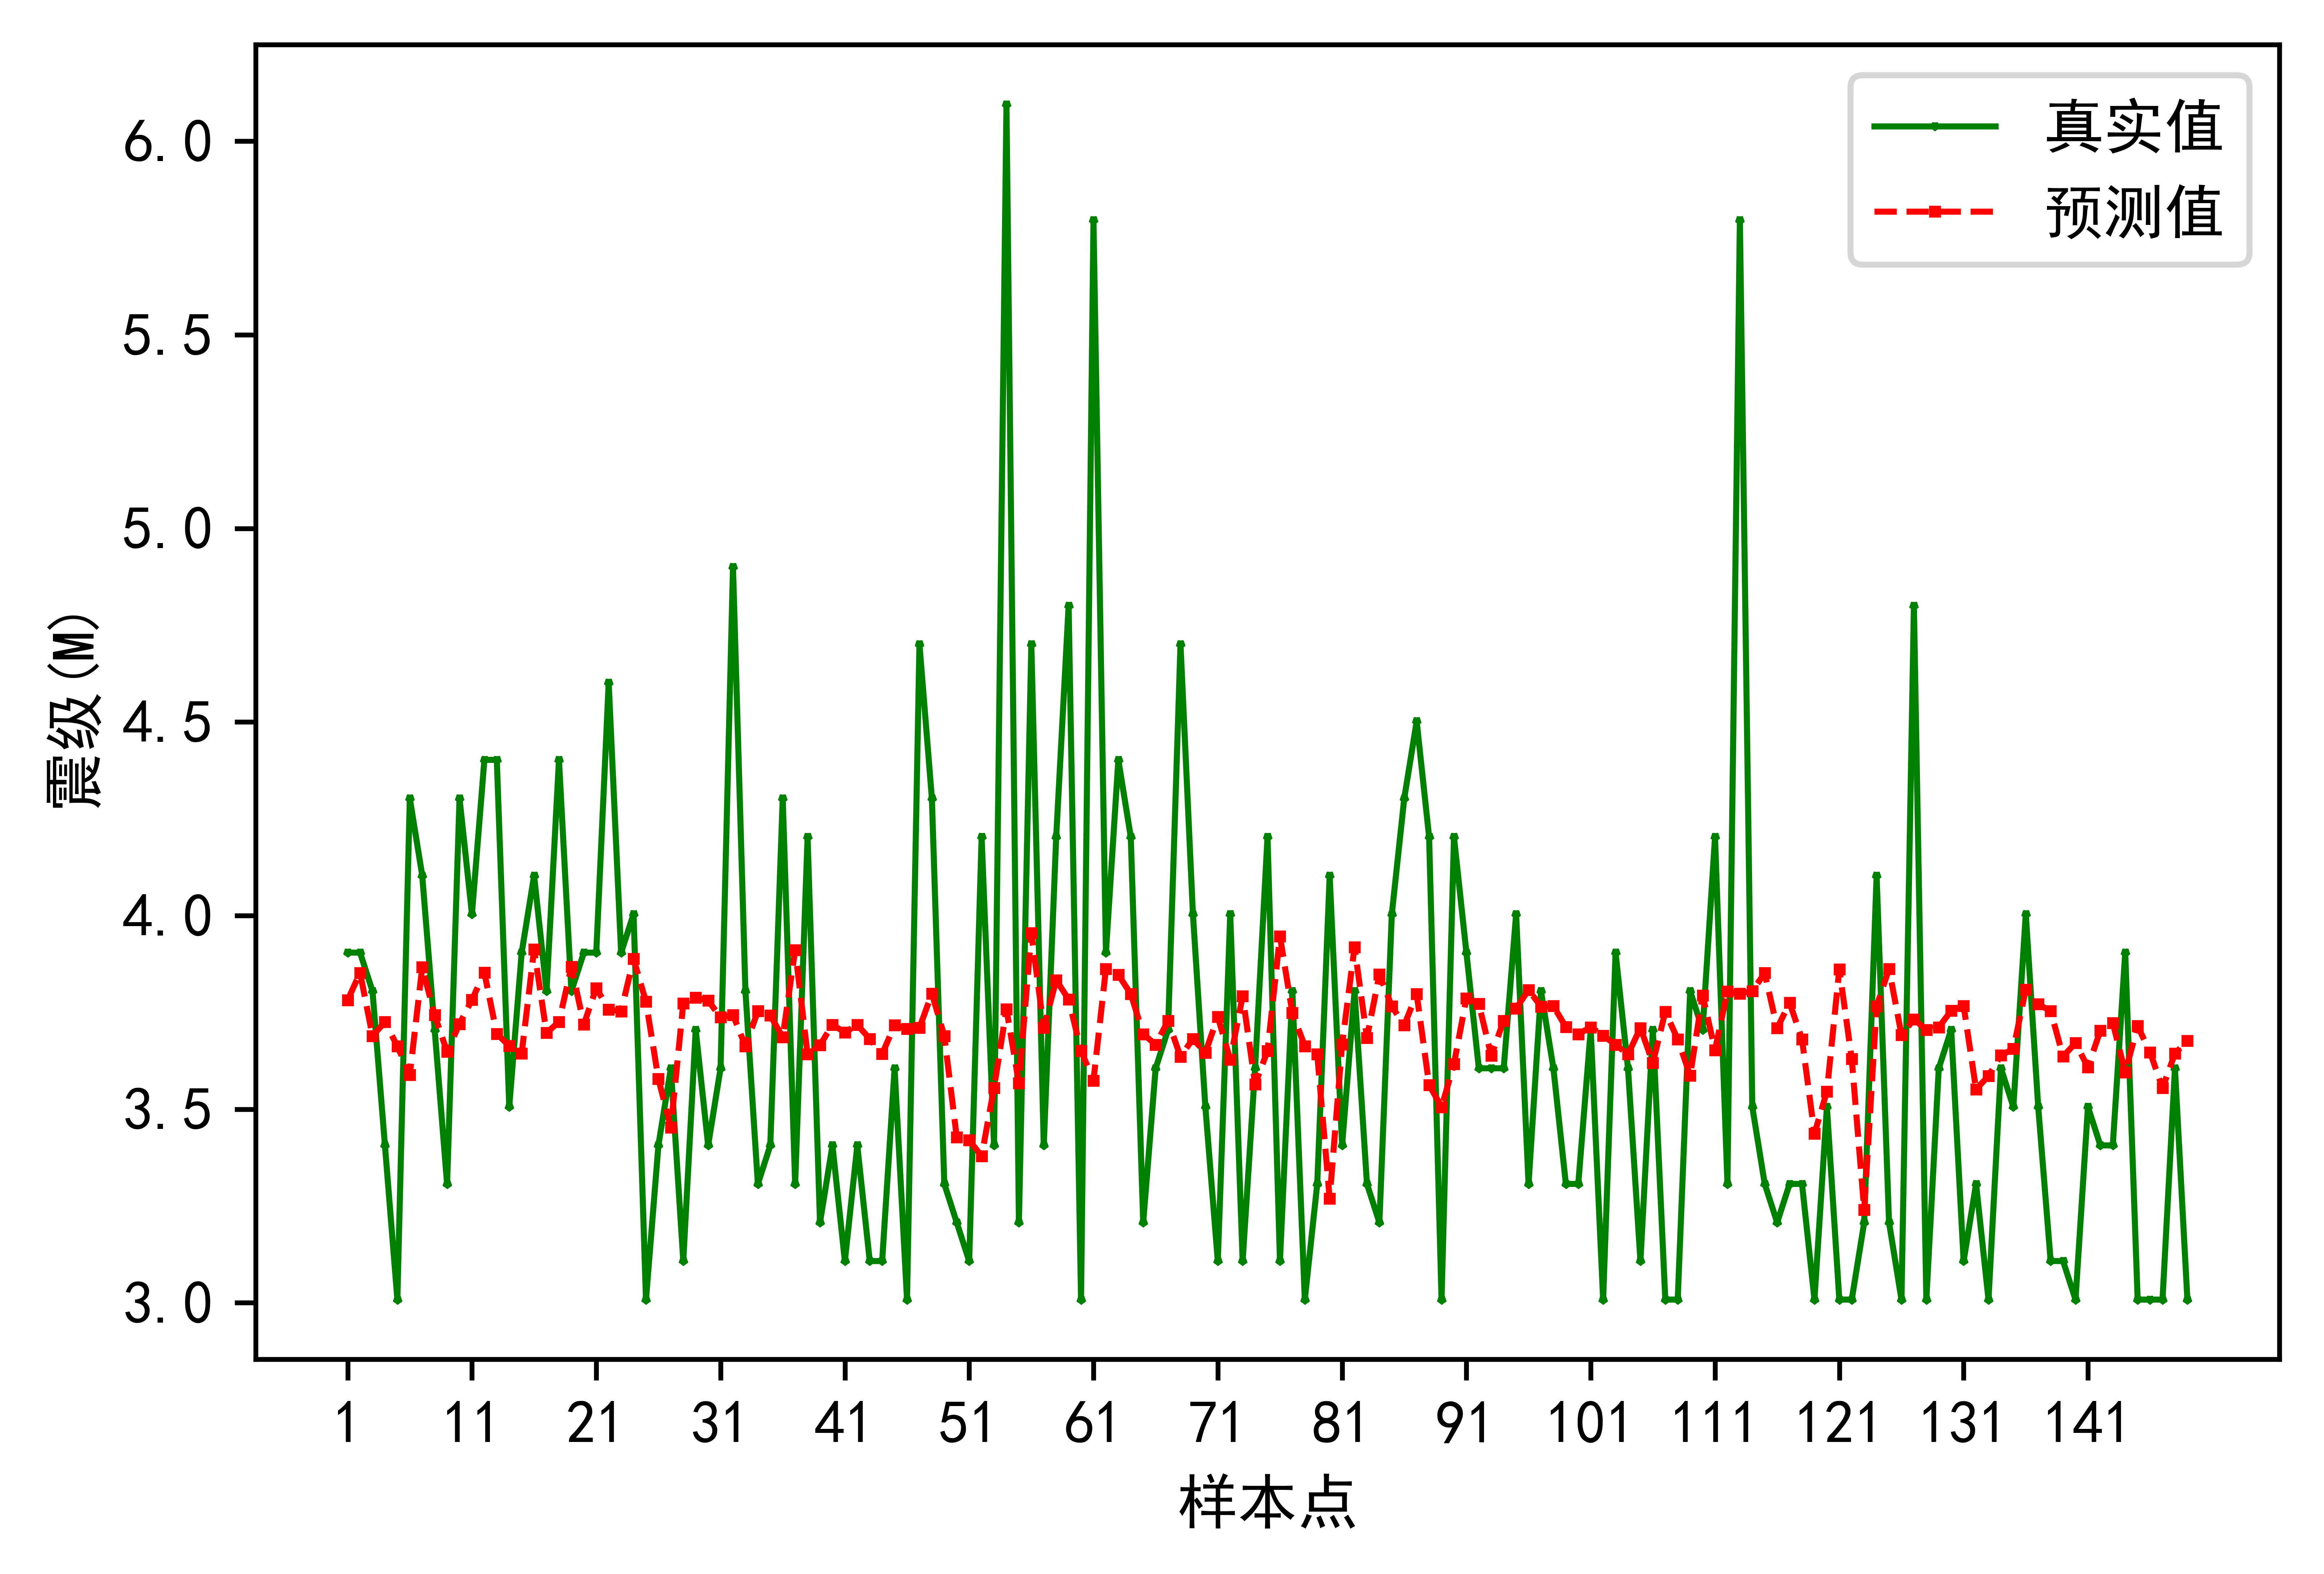

In [21]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
#添加网格线,linestyle表示绘制网格线的形式，alpha表示透明度
# plt.grid(True,linestyle="--",alpha=0.5)  
x=range(1, len(inv_yhat) + 1)
plt.xticks(x[::10])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, marker='*',markersize='1',color='g',linewidth=1, label='真实值')
plt.plot(x, inv_yhat, marker='s',markersize='1', color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("震级(M)",fontsize=10)
plt.legend()
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('西藏十年BP震级预测结果图.png')
plt.show()